# Random Walk Analysis of the S&P 500

_wherein I apply some basic random walk analysis to look into the future_

My goal here is to play with random walk modeling of a simple time series, in this case using the stock market. I don't get into test data, taking out chunks of stock market history and seeing if the model reproduces the result. What you will see is that the stock market, here using the S&P 500 as a proxy, is pretty mindlessly an exponential curve, with considerable but not insane fluctuations that create uncertainty about the exact value in the future, but which behaves pretty predictably overall.

In [1]:
# Standard imports
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns

from tqdm.notebook import tqdm

# needed for our loss plots
from IPython.display import clear_output

# using inline, have to set the figure bigger
%matplotlib inline

# set figure parameters so they look pretty
import matplotlib.pylab as pylab

# Use the Gill Sans font
import matplotlib.font_manager as fm
font = fm.FontProperties(
       family = 'Gill Sans',
       fname = '/usr/share/fonts/truetype/adf/GilliusADF-Regular.otf')
params = {'legend.fontsize': 14,
          'figure.figsize': (9.5, 6),
         'axes.labelsize': 14,
         'axes.titlesize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False,
         'font.family' : 'Gill Sans'}
pylab.rcParams.update(params)

# I like to have more colors than what are available, so define tableau20 colors:
tableau20={
    'deep_blue' : (31, 119, 180), 'light_blue' : (174, 199, 232),
    'deep_orange' :  (255, 127, 14), 'light_orange' : (255, 187, 120), 
    'deep_green' :(44, 160, 44), 'light_green' : (152, 223, 138),
    'deep_red' : (214, 39, 40), 'light_red' : (255, 152, 150), 
    'deep_violet' : (148, 103, 189), 'light_violet' : (197, 176, 213), 
    'deep_brown' : (140, 86, 75), 'light_brown': (196, 156, 148), 
    'deep_pink' : (227, 119, 194), 'light_pink' : (247, 182, 210), 
    'deep_gray' : (127, 127, 127), 'light_gray' : (199, 199, 199), 
    'deep_olive' : (188, 189, 34), 'light_olive' : (219, 219, 141), 
    'deep_cyan' : (23, 190, 207), 'light_cyan' : (158, 218, 229)
}

for key in tableau20.keys():    
    r, g, b = tableau20[key]    
    tableau20[key] = (r / 255., g / 255., b / 255.) 

# Data Exploration

First, we need data to look at. I've extracted the S&P 500 data from [Yahoo! finance](https://finance.yahoo.com/quote/%5EGSPC/history/), but the date data isn't quite in a Python-friendly format at first. It's also good to take a long look at the raw data, to look for general trends that we might want to pull out (**hint**: this is foreshadowing, there is, and we will).

In [2]:
# load in the S&P 500 historical data
sp500_df = pd.read_csv('../data/GSPC.csv')

# define an array that measures in years -- we'll need it for fitting later

# convert everything to a datetime object
sp500_df['Date']      = pd.to_datetime(sp500_df.Date)
sp500_df['DayOfYear'] = sp500_df.Date.dt.dayofyear
sp500_df['Year']      = sp500_df.Date.dt.year
sp500_df['Month']     = sp500_df.Date.dt.month
sp500_df['Day']       = sp500_df.Date.dt.day

In [3]:
# take a peak at the structure of the data
sp500_df.head()
sp500_df.tail()

sp500_df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfYear,Year,Month,Day
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,364,1927,12,30
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,3,1928,1,3
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,4,1928,1,4
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,5,1928,1,5
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,6,1928,1,6


,Date,Open,High,Low,Close,Adj Close,Volume,DayOfYear,Year,Month,Day
23207,2020-05-22,2948.050049,2956.760010,2933.590088,2955.449951,2955.449951,3952800000,143,2020,5,22
23208,2020-05-26,3004.080078,3021.719971,2988.169922,2991.770020,2991.770020,5837060000,147,2020,5,26
23209,2020-05-27,3015.649902,3036.250000,2969.750000,3036.129883,3036.129883,6371230000,148,2020,5,27
23210,2020-05-28,3046.610107,3068.669922,3023.399902,3029.729980,3029.729980,5402670000,149,2020,5,28
23211,2020-05-29,3025.169922,3049.169922,2998.610107,3044.310059,3044.310059,7275080000,150,2020,5,29


,Open,High,Low,Close,Adj Close,Volume,DayOfYear,Year,Month,Day
count,23212.000000,23212.000000,23212.000000,23212.000000,23212.000000,2.321200e+04,23212.000000,23212.000000,23212.000000,23212.000000
mean,473.377600,476.153637,470.423003,473.474768,473.474768,7.509692e+08,182.486946,1973.793167,6.501120,15.761890
std,701.285181,704.998065,697.231435,701.381784,701.381784,1.463116e+09,104.852943,26.660129,3.431807,8.739473
min,4.400000,4.400000,4.400000,4.400000,4.400000,0.000000e+00,2.000000,1927.000000,1.000000,1.000000
25%,23.767500,23.767500,23.767500,23.767500,23.767500,1.250000e+06,92.000000,1951.000000,4.000000,8.000000
50%,99.174999,99.994999,98.365002,99.185001,99.185001,1.695000e+07,182.000000,1974.000000,7.000000,16.000000
75%,790.977508,802.184998,783.802490,791.505005,791.505005,4.997725e+08,273.000000,1997.000000,9.000000,23.000000
max,3380.449951,3393.520020,3378.830078,3386.149902,3386.149902,1.145623e+10,366.000000,2020.000000,12.000000,31.000000


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


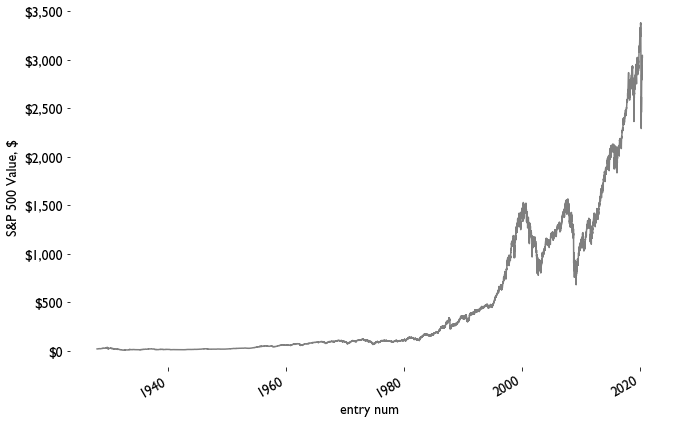

In [4]:
# lets look at the long term trend for the opening value
fig, ax = plt.subplots()
ax.plot(sp500_df.Date, sp500_df.Open, c=tableau20['deep_gray'])
ax.set_xlabel('entry num')
ax.set_ylabel('S&P 500 Value, $')

ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: '$'+format(int(x), ',')));

fig.autofmt_xdate()

fig.tight_layout()
fig.savefig('sp500.png', bbox_inches="tight");
fig.show();

To the untrained eye, it looks like basically nothing happened until about 1980, and then everything went nuts. If you know what you're looking at, this is a trait of exponential growth. It's far easier to see exponential growth on a semilog plot...

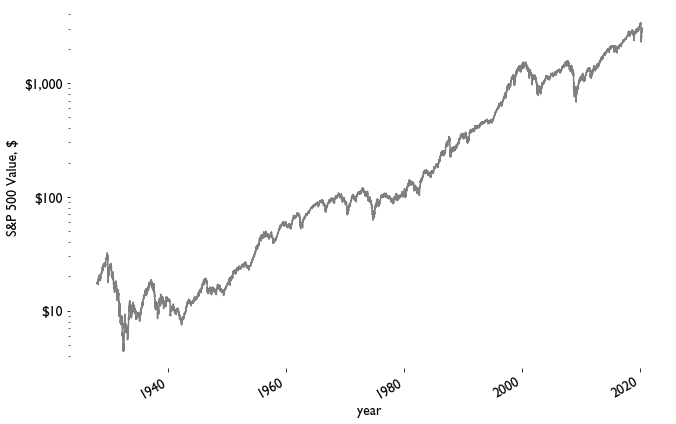

In [5]:
# Compare the fit to the real data on a semi-log plot
fig, ax = plt.subplots()
ax.semilogy(sp500_df.Date, sp500_df['Open'], c=tableau20['deep_gray'], label='S&P 500 data')
ax.set_xlabel('year')
ax.set_ylabel('S&P 500 Value, $')

ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: '$'+format(int(x), ',')));

#ax.legend()
fig.autofmt_xdate()

fig.tight_layout()
fig.savefig('sp500_semilog.png', bbox_inches="tight");

# Fitting the mean growth

This curve looks like it has an exponential growth trend to it, so it would be good to isolate the exponential growth and look at a time-normalized value for the S&P 500.

We will fit a curve of the form

$$
\textrm{val}(t) = \textrm{val}(0) ~ 2^{t/\tau}
$$

to find the growth constant $\tau$ that tells us the rate per trading day of S&P 500 growth. We will then subtract off this general trend line to look at shorter-time variations.

One thing that's important when fitting exponential data to a curve is to actually fit the $\log$ of the exponential data to the $\log$ of the curve to fit. This is because a cost function like $L_2$ will punish you exponentially more for data that occurs later in time than earlier. Taking the logarithm allows us to try to fit a line to the data, which gives a much more accurate calculation of $\tau$, the main parameter of interest.

In [6]:
# Fit an exponential curve to the closing date, so we can normalize to the local average
t_years = np.linspace(0, len(sp500_df['Open']), len(sp500_df['Open']))/(365-104-12)
(oneOtau, a), cov = np.polyfit(t_years, np.log(sp500_df['Open'])/np.log(2.), 1, full = False, cov=True)
exp_fit = 2.**(oneOtau * t_years + a)
sigma_t = np.sqrt(np.abs(cov))[0,0]
print(np.sqrt(np.abs(cov)))
print('time constant tau = {} trading years'.format(1/oneOtau))
print('correction ~ {}'.format(np.sqrt(np.abs(cov[0,0]))/oneOtau))

[[0.00012877 0.00087915]
 [0.00087915 0.00693076]]
time constant tau = 10.679648591684117 trading years
correction ~ 0.0013752470583300418


Because of the exponential growth over many growth cycles, comparing goodness of fit to the data is best done visually on a semi-log plot. Exponential growth will appear as a straight line with slope $1/\tau$. It's worth remembering that trading days are weekdays other than certain holidays, so in reality there's about 250 trading days per calendar year. That puts the doubling time at around 7 years, which is historically about right.

To see how well this fits, let's look at our curve fit compared to the actual performance on a semilog plot:

Text(0.5, 0, 'year')

Text(0, 0.5, 'S&P 500 Value, $')

doubling growth time = 10.679648591684117 years


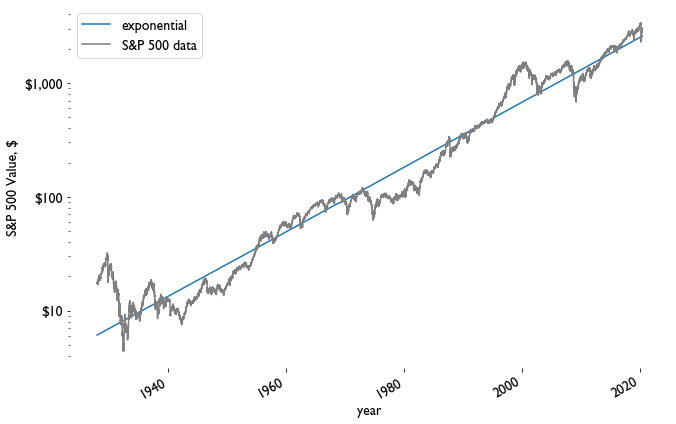

In [7]:
# Compare the fit to the real data on a semi-log plot
fig, ax = plt.subplots();
ax.semilogy(sp500_df.Date, exp_fit, c=tableau20['deep_blue'], label='exponential');
ax.semilogy(sp500_df.Date, sp500_df['Open'], c=tableau20['deep_gray'], label='S&P 500 data');
ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: '$'+format(int(x), ',')));
ax.set_xlabel('year');
ax.set_ylabel('S&P 500 Value, $');

ax.legend();
fig.autofmt_xdate();

fig.tight_layout();
fig.savefig('exp_fit.png', bbox_inches="tight");

print('doubling growth time = {} years'.format(1/oneOtau))

That is remarkably exponential with the same growth rate for a remarkable amount of time. Those ups and downs have gone through all of 20th century history

## Historical Context

That's a pretty consistent exponential growth from the bottom of the Great Depression, around 1933, until today. It might help to look at those bumps and dips in historical context.

doubling growth time = 10.679648591684117 years


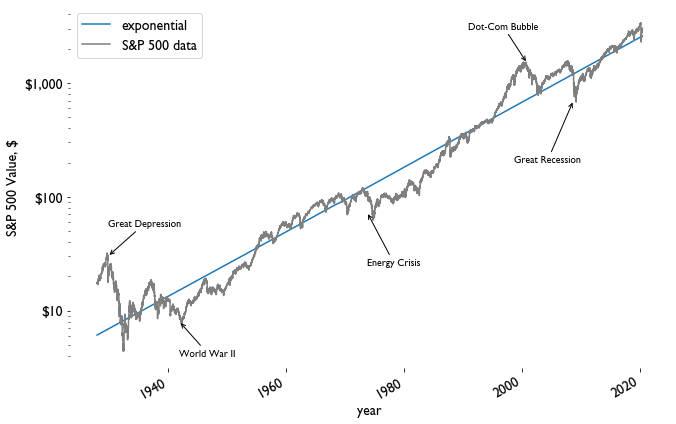

In [8]:
# Create an annotated curve for historical events
fig, ax = plt.subplots()

# Black Tuesday, the market crash that began the Great Depression
black_tuesday = dt.datetime(1929, 10, 29)
ax.annotate('Great Depression', xy=(black_tuesday, 30), xytext=(black_tuesday, 55),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

# Pearl Harbor attack
pearl_harbor = dt.datetime(1941, 12, 7)
ax.annotate('World War II', xy=(pearl_harbor, 8), xytext=(pearl_harbor, 4),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

# The day OPEC began the oil embargo on the US
energy_crisis = dt.datetime(1973, 10, 1)
ax.annotate('Energy Crisis', xy=(energy_crisis, 73), xytext=(energy_crisis, 25),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

# pets.com goes bankrupt nine months after an ~$85mn IPO
pets_dot_com = dt.datetime(2000, 11,9)
pets_dot_com_label = dt.datetime(1990, 11,9)
ax.annotate('Dot-Com Bubble', xy=(pets_dot_com, 1500), xytext=(pets_dot_com_label, 3000),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

# Lehman Brothers folds
lehman_brothers = dt.datetime(2008, 9, 20)
lehman_brothers_label = dt.datetime(1998, 9, 20)
ax.annotate('Great Recession', xy=(lehman_brothers, 700), xytext=(lehman_brothers_label, 200),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            );

ax.semilogy(sp500_df.Date, exp_fit, c=tableau20['deep_blue'], label='exponential');
#ax.fill_between(sp500_df.Date, exp_fit_plus, exp_fit_minus, c=tableau20['light_blue'])
ax.semilogy(sp500_df.Date, sp500_df.Open, c=tableau20['deep_gray'], label='S&P 500 data');
fig.autofmt_xdate();

ax.set_xlabel('year');
ax.set_ylabel('S&P 500 Value, $');

ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: '$'+format(int(x), ',')))

ax.legend();
fig.tight_layout();
fig.savefig('exp_fit_annotated.png', bbox_inches="tight");

print('doubling growth time = {} years'.format(1/oneOtau));

A few interesting notes

1. This is a pretty good exponential fit, considering this data starts in 1927 and ends in 2020
2. From this, you expect the S&P 500 value to increase e-fold (2.72x) every 10.5 years, which is good to know from a financial planning standpoint

## Normalizing the Growth

Because that trend is so strong, it may be useful to forecast fluctuations _around_ the trend. We can add back the exponential curve later. To do this, we divide the data by the exponential fit, so that we normalize all of the values of the S&P 500 to what it "should" have been. Thus, a value greater than $0$ is doing better than expected, and less than $0$ is doing worse than expected.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


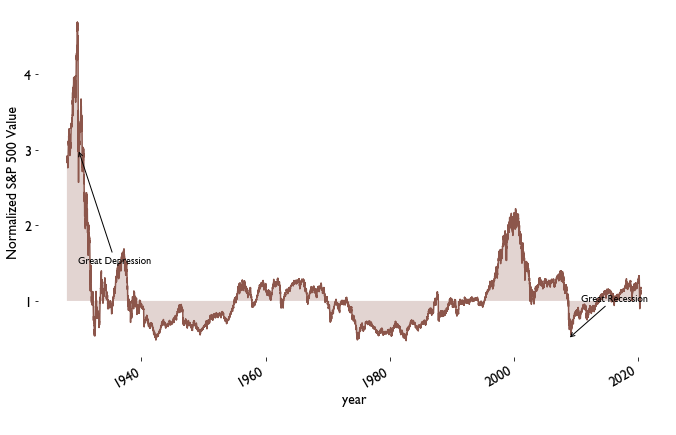

In [9]:
# Create a normed Open value
sp500_df['Open_norm'] = sp500_df['Open']/exp_fit

fig, ax = plt.subplots()
ax.plot(sp500_df.Date, sp500_df['Open_norm'], c=tableau20['deep_brown'])
ax.fill_between(sp500_df.Date, 1., sp500_df['Open_norm'], facecolor=tableau20['deep_brown'], alpha=0.25)

black_tuesday = dt.datetime(1929, 10, 29)
ax.annotate('Great Depression', xy=(black_tuesday, 3), xytext=(black_tuesday, 1.5),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )
pearl_harbor = dt.datetime(1941, 12, 7)
ax.annotate('World War II', xy=(pearl_harbor, 0), xytext=(pearl_harbor, .5),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )

energy_crisis = dt.datetime(1973, 10, 1)
ax.annotate('Energy Crisis', xy=(energy_crisis, 0.), xytext=(energy_crisis, .5),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )

lehman_brothers = dt.datetime(2008, 9, 20)
lehman_brothers_label = dt.datetime(2010, 9, 20)
ax.annotate('Great Recession', xy=(lehman_brothers, .5), xytext=(lehman_brothers_label, 1.),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )

pets_dot_com = dt.datetime(2000, 11,9)
pets_dot_com_label = dt.datetime(1990, 11,9)
ax.annotate('Dot-Com Bubble', xy=(pets_dot_com, 0.), xytext=(pets_dot_com_label, -.65),
            arrowprops=dict(facecolor='black', arrowstyle="->",
                            connectionstyle="arc3"),
            )

ax.set_xlabel('year')
ax.set_ylabel('Normalized S&P 500 Value')

fig.autofmt_xdate();

fig.tight_layout()
fig.savefig('sp500_normed.png', bbox_inches="tight")
fig.show();

It's a testament to policy that, after the Great Depression, we got very good at steady long term growth for most of the next hundred years. Right up until pets.com ruined the fun.

# Statistical Properties of the S&P 500

To forecast the fluctuations, we need to build a model of the statistics of those fluctuations. This will involve looking at the statistical distribution of daily percent changes, and how the performance once day might affect the performance the next. We can use this data to construct a *random walk* model for the S&P 500. But first, we need to look at the statistical behavior of the market day-to-day.

## Daily Variations in the Market

To analyze day-to-day variations and predict market variances, it would be useful to see if percent changes from day to day are correlated statistically, and to then develop a statistical model for that. First, we add a Pandas column for the percent change from day to day, and then we will look at temporal correlations. 

In [10]:
# compute percent change day to day, and look at some of the data
sp500_df['PercentChange'] = sp500_df['Close'].pct_change()

pc_mean = np.mean(sp500_df.PercentChange)
pc_std = np.std(sp500_df.PercentChange)
pc_max = np.max(sp500_df.PercentChange)
pc_min = np.min(sp500_df.PercentChange)

sp500_df.PercentChange.describe()

count    23211.000000
mean         0.000294
std          0.011995
min         -0.204669
25%         -0.004528
50%          0.000473
75%          0.005394
max          0.166096
Name: PercentChange, dtype: float64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


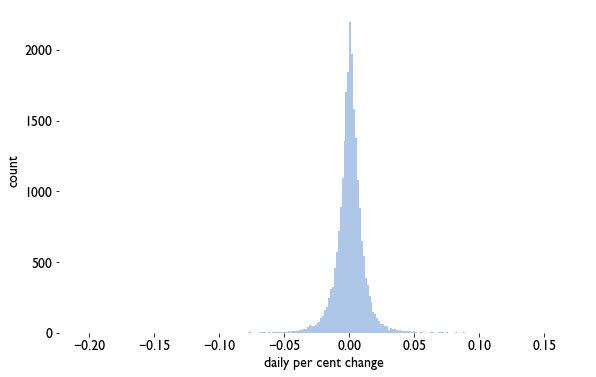

In [11]:
n_bins = 250
fig, ax = plt.subplots()
ax.hist(sp500_df.PercentChange, bins=n_bins, color=tableau20['light_blue'])
ax.plot()
ax.set_xlabel(r'daily per cent change')
ax.set_ylabel(r'count')

fig.show();

The default plan for many people would be to model this curve as a gaussian. However, its peak is too sharp and tails too long to be gaussian. To illustrate this, we compare fitting a gaussian curve with an exponential

In [12]:
def exp_fit_func(x, mu, sigma, a):
    return a * np.exp(- np.abs(x - mu)/sigma)/(2.*sigma)

def gauss_fit_func(x, mu, sigma, a):
    return a * np.exp(-(x - mu)**2/(2.*sigma**2))/np.sqrt(2.*np.pi*sigma)

In [13]:
# get the histogram data
counts, bins = np.histogram(sp500_df.PercentChange, bins=n_bins, range=(pc_min, pc_max))
bins_c = np.array([0.5 * (bins[idx] + bins[idx+1]) for idx in range(len(bins)-1)])

# fit the exponential
popt_exp, pcov_exp = curve_fit(exp_fit_func, xdata=bins_c, ydata=counts, p0=[ pc_mean, pc_std, np.max(counts)])
popt_gauss, pcov_gauss = curve_fit(gauss_fit_func, xdata=bins_c, ydata=counts, p0=[ pc_mean, pc_std, np.max(counts)])

# and compute the residual L2 norm
exp_residual = np.sum(np.abs(exp_fit_func(bins_c, *popt_exp) - counts))
gauss_residual = np.sum(np.abs(gauss_fit_func(bins_c, *popt_gauss) - counts))

# and print the model results
print('exp fit \n mu = {} +/- {} \n sigma = {} +/- {} \n a = {} +/- {}'.format(
    popt_exp[0], pcov_exp[0,0], popt_exp[1], pcov_exp[1,1], popt_exp[2], pcov_exp[2,2]))
print('exp fit residual = {}'.format(exp_residual))

print('gauss fit \n mu = {} +/- {} \n sigma = {} +/- {} \n a = {} +/- {}'.format(
    popt_gauss[0], pcov_gauss[0,0], popt_gauss[1], pcov_gauss[1,1], popt_gauss[2], pcov_gauss[2,2]))
print('gauss fit residual = {}'.format(gauss_residual))

exp fit 
 mu = 0.0008150159740259162 +/- 8.046337326073632e-10 
 sigma = 0.0072894414432182275 +/- 3.0593593075409927e-09 
 a = 34.42609876541094 +/- 0.033978317954866624
exp fit residual = 1694.7562033138474
gauss fit 
 mu = 0.0006297199068407922 +/- 6.390036823787148e-09 
 sigma = 0.0065909222470902805 +/- 6.390037467572226e-09 
 a = 378.6351029718074 +/- 10.54429469651853
gauss fit residual = 4404.157360483706


From the considerably lower exponential fit residuals, we can conclude that the exponential distribution is a better fit. But we can also see this with our own eyes.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


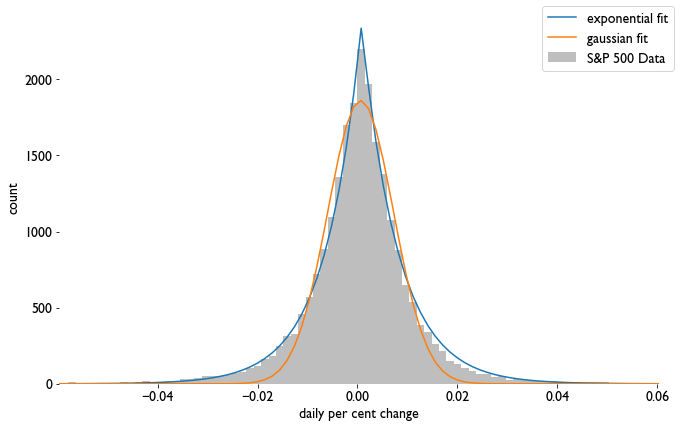

In [14]:
# plot the relative fits
fig, ax = plt.subplots()
ax.bar(bins_c, counts, width=bins[1] - bins[0], alpha=0.5, color='tab:gray', label='S&P 500 Data')
ax.plot(bins_c, exp_fit_func(bins_c, *popt_exp), c='tab:blue', label='exponential fit')
ax.plot(bins_c, gauss_fit_func(bins_c, *popt_gauss), c='tab:orange', label='gaussian fit')
ax.set_xlabel(r'daily per cent change')
ax.set_ylabel(r'count')
ax.set_xlim(left=pc_mean-5*pc_std, right=pc_mean+5*pc_std)

fig.legend()
fig.tight_layout()
fig.savefig('percent_change_fit_comparisons.png', bbox_inches="tight")
fig.show();

The exponential fit has a substantially smaller residual, and indeed it captures the sharpness of the peak as well as the width of the tails much better than the gaussian, which underestimates the peak as well as the tails. 

This is simply a distribution of individual day performance. However, as we know from experience, performance of the stock market one day tends to inform behavior the next. We will see this by looking at the day-to-day correlations in performance.

## Day-to-day correlations

Let's look at how the performance of one day will influence the performance the next few days. We can use this to build a time series model predicting probable future performances.

### Data Exploration

We want to look at single-day correlations, and how they may be distributed. Later, we will want to compute a distribution model that fits a function to the data so that, given how one day went, we can compute a distribution for how the next day went.

In [15]:
# first, split the historical data into two time-staggered lists
day0 = sp500_df.PercentChange[1:-2]
day1 = sp500_df.PercentChange[2:-1]

# compute the covariance matrix
print('Sigma = \n{}'.format(np.cov([day0, day1])))

Sigma = 
[[ 1.43888230e-04 -1.87818895e-06]
 [-1.87818895e-06  1.43887236e-04]]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


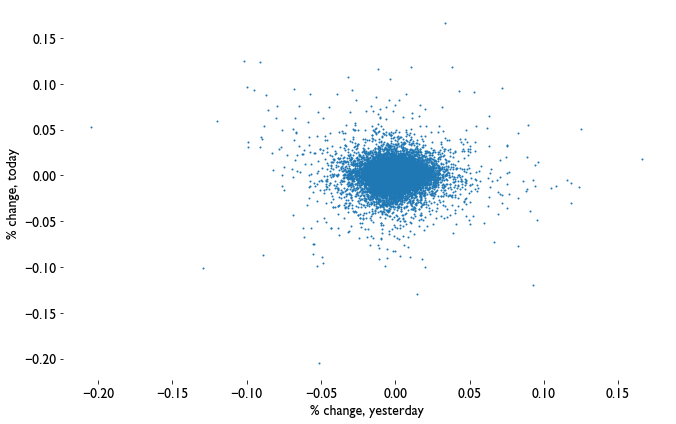

In [16]:
# now, plot a scatter plot of the data
fig, ax = plt.subplots()
ax.scatter(day0, day1, s=1)

ax.set_xlabel('% change, yesterday')
ax.set_ylabel('% change, today')

fig.tight_layout()
fig.savefig('time_correlation_percent_growth.png', bbox_inches="tight")
fig.show();

There is clearly some structure here -- it's not simply uncorrelated exponential noise.

**Nota Bene** A fun property of scatter plots is they tend to visually under-represent the core of a distribution. A better option is a 2D histogram.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


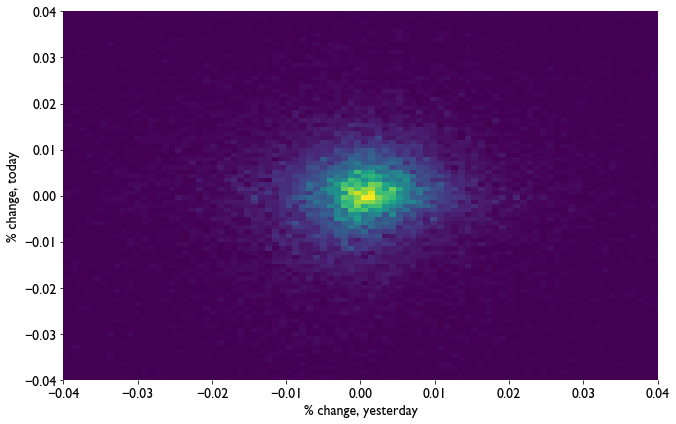

In [17]:
fig, ax = plt.subplots()
ax.hist2d(day0, day1, bins=400)

ax.set_xlabel('% change, yesterday')
ax.set_ylabel('% change, today')

# there is almost nothing outside this range
ax.set_xlim([-.04, .04])
ax.set_ylim([-.04, .04])

fig.tight_layout()
fig.savefig('time_correlation_percent_growth.png', bbox_inches="tight")
fig.show();

There's some correlation here. The off-diagonal covariance matrix elements are nonzero, for one thing. To see the correlation, plot the scatter plot atop the exponential distribution, which should reflect the statistical distribution of both axes.

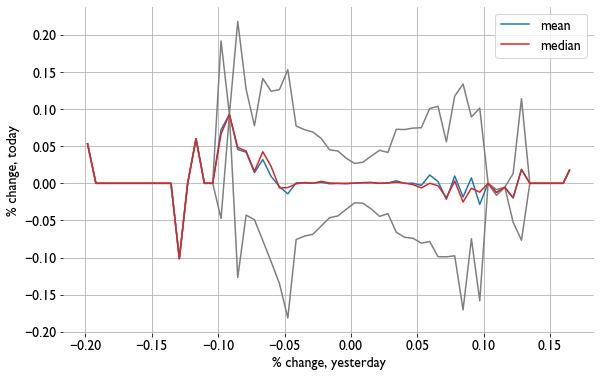

In [18]:
day0_bins = np.linspace(pc_min, pc_max, 60)

from scipy.stats import binned_statistic
means, edges, number = binned_statistic(day0, day1, statistic='mean', bins=day0_bins)
stds, edges, number  = binned_statistic(day0, day1, statistic='std', bins=day0_bins)
medians, edges, number = binned_statistic(day0, day1, statistic='median', bins=day0_bins)
count, edges, number = binned_statistic(day0, day1, statistic='count', bins=day0_bins)

means = np.nan_to_num(means)
medians = np.nan_to_num(medians)
stds = np.nan_to_num(stds)

# center the edges
for idx in range(0, len(edges)-1):
    edges[idx] = (edges[idx] + edges[idx+1])/2.

edges_c = np.array([0.5 * (edges[idx] + edges[idx+1]) for idx in range(len(edges)-1)])

    
fig, ax = plt.subplots()
ax.plot(edges_c, means, c='tab:blue', label='mean')
ax.plot(edges_c, means+3*stds, c='tab:gray')
ax.plot(edges_c, means-3*stds, c='tab:gray')
ax.plot(edges_c, medians, c='tab:red', label='median')
ax.set_xlabel(r'% change, yesterday')
ax.set_ylabel(r'% change, today')
ax.grid()
ax.legend();

Clearly, there's a non-zero mean for particularly bad days -- things go down badly enough and people smell a deal. We need to have a statistical model that can capture this. Which we'll now do.

All this confirms that the percent change statistical model to the normalized value is unchanged, which should be expected. We now need a way to sample from this distribution as a conditional probability. What we need... is a Metropolis-Hastings random walk algorithm.

## Random Walk Model of Daily S&P 500 Conditional Probability Density

Our ultimate goal is to be able to compute a random walk sequence for the daily performance $\{x_t\}$ from a statistical distribution $p(x_t | x_{t-1})$ which includes single-day correlations.

To build this model of the density, we first need a 2D interpolation on the normalized histogram we computed for the day-to-day correlation, so we can sample random new performance every day from the probability distribution, and build many many sequences of the stock market going, say, four years into the future. Once we have each stock market trajectory, relative to the secular trend, we can look at the statistics of those outcomes to predict a range of where the stock market may be in ten years in normalized dollar values.

But we need to compute $p(x | y)$, the probability of an $x$ percent change today given a $y$ percent change yesterday. Then every day we need to sample from that distribution as a random walk, eventually arriving at a series representing one version of the stock market after ten years of trading.

In [19]:
# first, compute the 2D histogram data
hist, xedges, yedges = np.histogram2d(day0, day1, bins = 250, density=True)

# center the edges
x_vals = [(xedges[idx] + xedges[idx+1])/2. for idx in range(0, len(xedges)-1)]
y_vals = [(yedges[idx] + yedges[idx+1])/2. for idx in range(0, len(yedges)-1)]

In [20]:
# Now, build a 2D interpolating function on that data
from scipy.interpolate import interp2d

daily_dist_func = interp2d(x_vals, y_vals, hist, kind='linear')

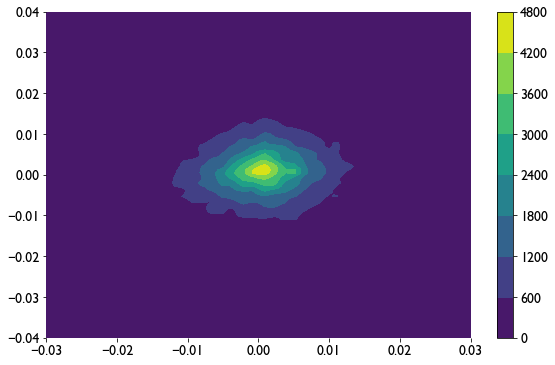

In [21]:
# Confirm that the interpolation isn't stupid
x = np.linspace(-.03, .03, 100)
y = np.linspace(-.04, .04, 100)

zz = daily_dist_func(x, y)

fig, ax = plt.subplots()

cm = ax.contourf(x, y, zz)
fig.colorbar(cm)

### Metropolis-Hastings sampler for sampling from the distribution for the random walk

That's a distribution to sample from. We're going to want to limit our sampling to be in the range $(-.05, .05)$ to avoid picking some sort of outlier.

Now we can employ a simple variant on [Metropolis-Hastings](https://sdwebb.github.io/2020/06/07/build-a-dist.html). One important thing to remember about Metropolis-Hastings is that the sequence it generates converges statistically to the probability distribution we want to sample from. However, the algorithm itself is a random walk, which means that over short times in the sequence the data can be quite correlated. Therefore, you want a short burnoff time to throw away the first few steps and get something that more accurately reflects the distribution rather than the initial seed.

There are a lot of `for` loops in here, which is very un-Pythonic and slows things down. This would suggest using Numba, but Numba does not play nicely with SciPy interpolation functions, so we're sorta stuck with waiting a long time. Aesthetically I'm not pleased with this Python implementation, but I haven't come up with anything better yet.

In [22]:
def random_MH(dist_func, y0, burnoff=10, sigma=1.):
    
    # burnoff period
    theta_t = sigma*np.random.random()
    
    idx = 0
    while idx < burnoff:
        theta_star = np.random.normal(loc=theta_t, scale=sigma)
        alpha = min(dist_func(theta_star, y0)/dist_func(theta_t, y0), 1.)
        u = np.random.random()
        if u < alpha:
            theta_t = theta_star
        idx += 1
            
    new_value = False
    while new_value == False:
        theta_star = np.random.normal(loc=theta_t, scale=sigma)
        alpha = min(dist_func(theta_star, y0)/dist_func(theta_t, y0), 1.)
        u = np.random.random()
        if u < alpha:
            new_value = True
            theta_t = theta_star
        return theta_t

As with any algorithm, it's important to validate that it's working on your dataset. So, for a quick sanity check, let's make sure that this implementation of Metropolis-Hastings is capturing the statistical distribution $p(x | y_0)$ for a fixed test $y_0$

In [23]:
# a quick sanity check that this is working correctly
n_samples = 10000
y0 = .01
samples = [random_MH(daily_dist_func, y0=y0, sigma=.01) for idx in range(0, n_samples)]

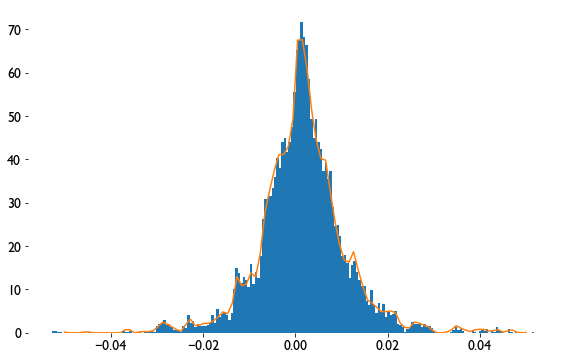

In [24]:
x=np.linspace(-.05, .05, 100);
fig, ax = plt.subplots()
ax.hist(samples, bins=200, density=True);
ax.plot(x, daily_dist_func(x, y=y0)/np.sum(daily_dist_func(x, y=y0)*(x[1]-x[0])));

### The Random Walk

Now that we know that we're doing a decent job sampling the distribution, we can build our random walk model.

Here we want to look at many, many versions of the stock market, where each version is a random walk that samples from our correlated daily distribution. Each day will have a random value generated based on the prior day. This will lead to a random walk sequence $\{x_t\}$ where each value samples from the probability distribution we just computed, $p(x_t | x_{t-1})$. The performance of a market after $N$ days will be the cumulative product:

$$
P_N = \prod_{t=0}^N (1 + x_t)
$$

We will first build a function that returns a single random walk, then we will sample many, many random walks to get a statistical idea of the market's performance for any given day. The initial seed condition will be the last value in our dataset's percent difference.

In [25]:
def random_walk(x_0, seq_length, random_generator, dist_func, sigma=1.):
    X = np.array([0.]*seq_length)
    x_tmin1 = x_0
    for idx in range(seq_length):
        x_new = random_generator(dist_func, x_tmin1, sigma=sigma)
        X[idx] = x_new
        x_tmin1 = x_new
    return X

Let's take a look at a single random walk over about four years of data.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


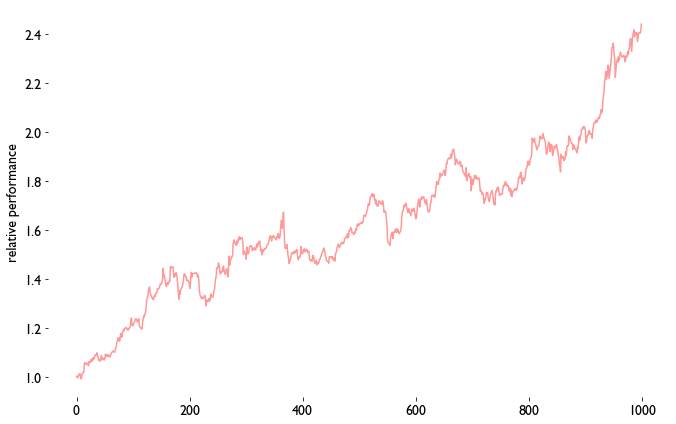

In [26]:
seq_length = 1000
x0 = sp500_df.Open_norm.iloc[-1]
X = random_walk(x0, seq_length, random_MH, daily_dist_func, sigma=.01)

fig, ax = plt.subplots();

ax.plot(np.cumprod(1.+X), c=tableau20['light_red']);
ax.set_ylabel('relative performance');

fig.tight_layout();

Of course, that's not deterministic, and we need to look over many, many sequences.

In [27]:
def generate_sequence(seq_length, n_samples):
    # Run the random walk
    X_data = np.zeros((seq_length, n_samples))
    for idx in tqdm(range(n_samples)):
        X_data[:,idx] = random_walk(sp500_df.Open_norm.iloc[-1], seq_length, random_MH, daily_dist_func, sigma=.01)
    return X_data

The runtime on this can get to be a bit long -- as I noted the `for` loops are very slow in normal Python, and the usual trick for speeding it up -- numba -- doesn't play nicely with my carefully interpolated distribution function. I use 100 samples, but if you were intrepid and didn't mind waiting you could use more, or run for longer. Because the data are a bit onerous to reproduce, I do save the output array to a `.npy` file.

In [31]:
n_samples = 1000
X_data = generate_sequence(seq_length, n_samples)
np.save('sp500_random_walk_data.npy', X_data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


### Projecting Forward

Using the ensemble of market behaviors we generated, we can now project out what can happen, with confidence bounds, for however long out. Remember that there are about $365 - 104 - 12 = 249$ trading days per calendar year, so $1,000$ for `seq_length` corresponds to about four years.

In [32]:
growth_factor = np.cumprod(1.+X_data, axis=0)
mean_growth = np.average(growth_factor, axis=1)
growth_var = np.std(growth_factor, axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


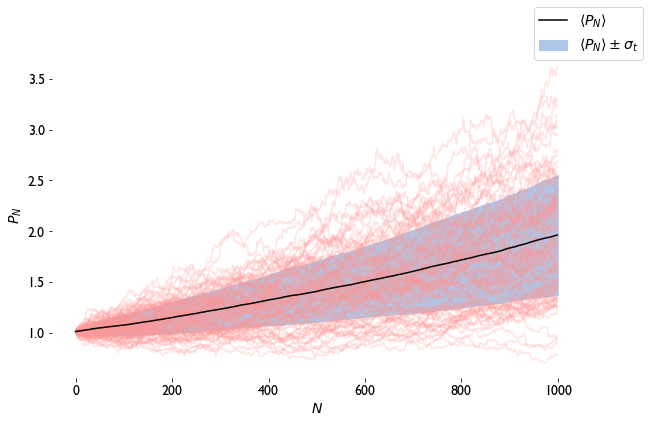

In [33]:
fig, ax = plt.subplots();

for idx in range(100):
    ax.plot(growth_factor[:,idx], alpha=.25, c=tableau20['light_red']);
    
ax.plot(mean_growth, c='k', label=r'$\langle P_N \rangle$')
x=np.linspace(0, len(mean_growth), len(mean_growth))
ax.fill_between(x, mean_growth-growth_var, mean_growth+growth_var, color=tableau20['light_blue'], label=r'$\langle P_N \rangle \pm \sigma_t$')

ax.set_ylabel(r'$P_N$');
ax.set_xlabel(r'$N$');
fig.legend();
fig.show();

There's always a few runaway outliers here, and running more sequences will get a model that converges to a bit more reliable range. Running this a few times, over $N=1000$ the net growth tends to be around $P_{1000} \sim 1.75 \pm .5$.

# Concluding remarks

There you have it, a random walk model for the S&P 500 that builds and samples from a probability distribution of prior data. This was not a full and proper data science modeling project: there's no test set to see if this random walk model can successfully capture the range between 1970 and 1975, for example, based only on data up to 1970. One conclusion from this is that the market tends to, if anything, overperform the exponential growth curve by a little bit. I think the computed growth is actually deflated by the Great Depression. It wouldn't be that hard for you, the reader, to adapt this code a little and check that.